Resolutions from config: ('1000000:1Mb',)
Extracted resolution: 1000000, label: 1Mb


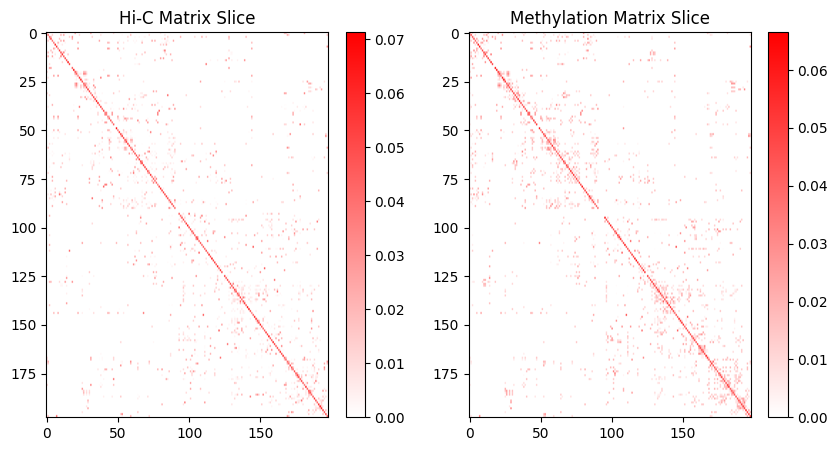

Statistics for Hi-C Matrix:
Shape: (198, 198)
Min: 0.0
Max: 0.07130584660084416
Number of non-zeros: 2477
Norm: 1.0000000000000002
Norm of each column: [0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.         0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158 0.07198158
 0.07198158 0.07198158 0.07198158 0.07198158 0.07198

In [14]:
import sys
import os

# Determine the current working directory (assuming you are running this in an interactive environment)
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
sys.path.append(parent_dir)

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from matplotlib.colors import LinearSegmentedColormap
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

def normalize_matrix_columns(A):
    column_norms = np.linalg.norm(A, axis=0)
    zero_norms = column_norms == 0
    column_norms[zero_norms] = 1
    normalized_A = A / column_norms
    normalized_A[:, zero_norms] = 0
    return normalized_A

def load_csr_matrix_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        data = file['Matrix/data'][:]
        indices = file['Matrix/indices'][:]
        indptr = file['Matrix/indptr'][:]
        shape = file['Matrix'].attrs['shape']
    return csr_matrix((data, indices, indptr), shape=shape)

def normalize_matrix(A):
    norm = np.linalg.norm(A)
    if norm == 0:
        return A
    return A / norm

def csr_pearson_correlation(csr_mat):
    """Calculates Pearson correlation from a CSR matrix."""
    csc_mat = csr_mat.tocsc()
    mean = np.array(csc_mat.mean(axis=1)).flatten()
    std_dev = np.sqrt(csc_mat.power(2).mean(axis=1).A1 - mean**2)
    valid_std_dev = std_dev != 0
    rows, cols = csr_mat.nonzero()
    standardized_data = np.divide(csr_mat.data - mean[rows], std_dev[rows], where=valid_std_dev[rows])
    standardized_csr = csr_matrix((standardized_data, (rows, cols)), shape=csr_mat.shape)
    correlation_matrix = standardized_csr.dot(standardized_csr.T).toarray()
    diag = np.sqrt(np.diag(correlation_matrix))

    # Adjusting diagonal for valid standard deviations
    diag = np.where(valid_std_dev, diag, 1)  # replace zero with one to avoid division by zero
    correlation_matrix /= diag[:, None]
    correlation_matrix /= diag[None, :]
    return csr_matrix(np.nan_to_num(correlation_matrix))  # Replace NaNs with zero, caused by division by zero

def make_matrix_non_negative(matrix):
    # Convert the input to a NumPy array for easy manipulation
    matrix = np.array(matrix)
    
    # Find the minimum value in the matrix
    min_value = np.min(matrix)
    
    # Calculate the value needed to add to make all elements non-negative
    if min_value < 0:
        offset = -min_value
    else:
        offset = 0
    
    # Add the offset to every element in the matrix
    new_matrix = matrix + offset
    
    return new_matrix

def symmetric_nmf(matrix, rank):
    model = NMF(n_components=rank, init='random', random_state=0)
    W = model.fit_transform(matrix)
    H = model.components_
    reconstructed_matrix = np.dot(W, H)
    return reconstructed_matrix

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]
resolution, resolution_label = parse_resolution(resolution_str)

print(f"Extracted resolution: {resolution}, label: {resolution_label}")

methy_file_path = f'../../../projects/single_cell_files/methy_{resolution_label}_outerproduct_dir/chr3/sc12.GCCAAT_outer_product.h5'
hic_file_path = f'../../../projects/single_cell_files/hic_{resolution_label}_emphasized_dir/chr3/sc12.GCCAAT_chr3.h5'

with h5py.File(methy_file_path, 'r') as hf:
    dataset_name = list(hf.keys())[0]  
    methy_matrix = hf[dataset_name][:]

# Load the Hi-C matrix
hic_matrix = load_csr_matrix_from_hdf5(hic_file_path)

# Convert to dense matrix and drop the last row and column
hic_matrix_dense = hic_matrix.toarray()
#hic_matrix = hic_matrix_dense[:-2, :-2]
hic_matrix = hic_matrix_dense

#######################
# Assuming methy_matrix and hic_matrix are already defined
#rows, cols = hic_matrix.shape

# Create a mask of the same shape as the matrices
#mask = np.zeros((rows, cols), dtype=bool)

# Identify non-zero entries in hic_matrix
#non_zero_indices = np.nonzero(hic_matrix)

#for i, j in zip(*non_zero_indices):
#    # Set the mask for the entry and its surrounding entries
#    for di in range(-1, 2):
#        for dj in range(-1, 2):
#            if 0 <= i + di < rows and 0 <= j + dj < cols:
#                mask[i + di, j + dj] = True

# Set entries of methy_matrix to zero where mask is False
#methy_matrix[~mask] = 0
################################

methy_matrix[hic_matrix == 0] = 0
#hic_matrix = np.dot(hic_matrix, np.transpose(hic_matrix))

methy_matrix = csr_matrix(methy_matrix)
methy_matrix = make_matrix_non_negative(csr_pearson_correlation(methy_matrix).toarray())
hic_matrix = csr_matrix(hic_matrix)
hic_matrix = make_matrix_non_negative(csr_pearson_correlation(hic_matrix).toarray())

# For all zero entries in hic_matrix, make corresponding entries in methy_matrix zero


# Normalize each matrix so that each column has a norm of 1
hic_matrix = normalize_matrix_columns(hic_matrix)
methy_matrix = normalize_matrix_columns(methy_matrix)

# Convert the matrices to CSR format
#hic_matrix = csr_matrix(hic_matrix)
#methy_matrix = csr_matrix(methy_matrix)

# Take the symmetric NMF rank 10 of each matrix
#nmf_rank = 10
#hic_matrix = symmetric_nmf(hic_matrix, nmf_rank)
#methy_matrix = symmetric_nmf(methy_matrix, nmf_rank)

# Compute Pearson's correlation matrices using the CSR function
#hic_matrix = csr_pearson_correlation(hic_matrix).toarray()
#methy_matrix = csr_pearson_correlation(methy_matrix).toarray()

# Additional normalization step
hic_matrix = normalize_matrix(hic_matrix)
methy_matrix = normalize_matrix(methy_matrix)

# Custom colormap: zero to white, non-negative to red
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "red"])

# Plotting the slices of the tensor
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(hic_matrix, aspect='auto', cmap=cmap)
plt.colorbar()
plt.title('Hi-C Matrix Slice')

plt.subplot(1, 2, 2)
plt.imshow(methy_matrix, aspect='auto', cmap=cmap)
plt.colorbar()
plt.title('Methylation Matrix Slice')

plt.show()

# Calculating and printing statistics
def matrix_statistics(matrix, name):
    shape = matrix.shape
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    num_nonzeros = np.count_nonzero(matrix)
    norm = np.linalg.norm(matrix)
    column_norms = np.linalg.norm(matrix, axis=0)
    
    print(f"Statistics for {name}:")
    print(f"Shape: {shape}")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Number of non-zeros: {num_nonzeros}")
    print(f"Norm: {norm}")
    print(f"Norm of each column: {column_norms}")
    print()

matrix_statistics(hic_matrix, "Hi-C Matrix")
matrix_statistics(methy_matrix, "Methylation Matrix")
